In [34]:
pip install torchinfo

In [35]:
# Imports necessary libraries

# PyTorch core libraries
import torch  # Provides core functionalities for tensors and computation on GPU
import torch.nn as nn  # Helps in building neural networks by providing layers and modules
import torch.optim as optim  # Provides optimization algorithms such as Adam, SGD
from torchinfo import summary # provides text summary of the model
import torch.nn.functional as F # we will use activation functions this way

# PyTorch utilities for handling datasets
from torch.utils.data import Dataset, TensorDataset, DataLoader
# Dataset: Abstract class for all datasets
# TensorDataset: Wraps tensors into a dataset object
# DataLoader: Loads data in batches for training or testing
# Import random_split from PyTorch to split datasets into training and testing sets
from torch.utils.data import random_split


# Pandas for data manipulation
import pandas as pd  # Provides data structures like DataFrame for handling tabular data
# Numpy
import numpy as np

# Matplotlib for visualization
import matplotlib.pyplot as plt  # Used for plotting graphs and visualizing data

from IPython.display import clear_output, display

In [29]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
!git clone https://github.com/prokudin/PHYS496-Fall2024.git

fatal: destination path 'PHYS496-Fall2024' already exists and is not an empty directory.
fatal: destination path 'PHYS496-Fall2024' already exists and is not an empty directory.


In [31]:
# Path to the dataset (change this path if necessary)
filename1 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat'
filename2 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-4.dat'
filename3 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-5.dat'
filename4 = './PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-6.dat'

# Headers to skip (usually metadata or column labels in the file)
lines_to_skip = 5  # Skipping the first 5 lines which contain metadata

# Defining the columns (cv = central value, sd = standard deviation)
columns = ["x", "gluon_cv", "gluon_sd"]  # Columns represent x, gluon central value, and gluon standard deviation

# Read the data from the file and create a pandas DataFrame
df = pd.read_csv(filename1,
                 sep="\s+",  # The separator is whitespace
                 skiprows=lines_to_skip,  # Skip the first 5 lines
                 usecols=[0, 1, 2],  # Only use the first three columns (x, cv, sd)
                 names=columns)  # Name the columns as defined above

df

,x,gluon_cv,gluon_sd
0,0.001000,4.480675,0.523964
1,0.001007,4.478519,0.520743
2,0.001014,4.476361,0.517539
3,0.001021,4.474202,0.514349
4,0.001028,4.472040,0.511176
...,...,...,...
995,0.966051,-0.000712,0.002974
996,0.972747,-0.000634,0.002707
997,0.979490,-0.000494,0.002179
998,0.986279,-0.000302,0.001405


,x,gluon_cv,gluon_sd
0,0.001000,4.480675,0.523964
1,0.001007,4.478519,0.520743
2,0.001014,4.476361,0.517539
3,0.001021,4.474202,0.514349
4,0.001028,4.472040,0.511176
...,...,...,...
995,0.966051,-0.000712,0.002974
996,0.972747,-0.000634,0.002707
997,0.979490,-0.000494,0.002179
998,0.986279,-0.000302,0.001405


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
df.describe()

,x,gluon_cv,gluon_sd
count,1000.000000,1000.000000,1000.000000
mean,0.144121,2.386825,0.124490
std,0.226194,1.559152,0.109008
min,0.001000,-0.003120,0.000697
25%,0.005614,0.732704,0.040807
50%,0.031514,2.786095,0.118434
75%,0.176910,3.806944,0.137734
max,0.993116,4.480675,0.523964


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
df_all = df.copy()
df_all['gluon_cv'] += np.random.normal(0, df_all['gluon_sd'])
train_size = int(0.8 * len(df_all))
val_size = len(df_all) - train_size
df_train, df_test = random_split(df_all, [train_size, val_size])

In [39]:
def add_noise(tensor, mean=0.0, stddev=1.0):
    noise = torch.randn(tensor.size()) * stddev + mean
    return tensor + noise

def bootstrap(x, y, dy, n_samples):
  indices = np.random.choice(len(x), size=n_samples, replace=True)
  x_boot = x[indices]
  y_boot = y[indices]
  dy_boot = dy[indices]

  return x_boot, y_boot, dy_boot

In [40]:
# Prepare training data
# Convert data to PyTorch tensors and move to the specified device (CPU/GPU)
x_train = torch.tensor(df_train.dataset['x'].values.reshape(-1, 1)).float().to(device)    # Input features (x)
y_train = torch.tensor(df_train.dataset['gluon_cv'].values.reshape(-1, 1)).float().to(device) # Target values (gluon_cv)
dy_train = torch.tensor(df_train.dataset['gluon_sd'].values.reshape(-1, 1)).float().to(device) # Standard deviation (gluon_sd)

# Prepare testing data (similar to training data)
x_test = torch.tensor(df_test.dataset['x'].values.reshape(-1, 1)).float().to(device)    # Input features (x)
y_test = torch.tensor(df_test.dataset['gluon_cv'].values.reshape(-1, 1)).float().to(device)  # Target values (gluon_cv)
dy_test = torch.tensor(df_test.dataset['gluon_sd'].values.reshape(-1, 1)).float().to(device)  # Standard deviation (gluon_sd)

In [41]:
class ChiSquareLoss(nn.Module):
    def __init__(self):
        """
        Initialize the Chi-Square loss class, inheriting from nn.Module.
        This will allow us to use it like any other PyTorch loss function.
        """
        super().__init__()

    def forward(self, y_pred, y_true, dy_true):
        """
        Forward pass of the custom Chi-Square loss function.

        :param y_pred: Predicted values from the model (tensor of shape [batch_size, n_outputs]).
        :param y_true: True values or target values (tensor of shape [batch_size, n_outputs]).
        :param dy_true: Standard deviation of the true values (tensor of shape [batch_size, n_outputs]).

        :return: Computed chi-square loss (scalar tensor).
        """
        # Compute the chi-square loss as the mean of ( (y_true - y_pred) / sigma )^2
        loss = torch.mean(((y_true - y_pred) / dy_true) ** 2)
        return loss

In [42]:
# Create Torch Model

import torch
import torch.nn as nn
import torch.nn.utils.weight_norm as weight_norm

class Torch_Model(nn.Module):
    def __init__(self, n_features, n_neurons1, n_outputs):
        """
        Define the architecture of the neural network model.

        :param n_features: Number of input features (for example, 1 in this case).
        :param n_neurons1: Number of neurons in the first hidden layer.
        :param n_outputs: Number of output neurons (usually 1 for regression).
        """
        super().__init__()


        self.fc1 = nn.Linear(n_features, n_neurons1)  # Hidden Layer 1 (input features to first hidden layer)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_neurons1, n_neurons1 * 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(n_neurons1 * 2, n_neurons1 * 4)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(n_neurons1 * 4, n_neurons1 * 2)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(n_neurons1 * 2, n_neurons1)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(n_neurons1, n_outputs)

    def forward(self, x):
        """
        Forward pass of the network.

        :param x: Input tensor (of shape [batch_size, n_features]).
        :returns: Output tensor (of shape [batch_size, n_outputs]).
        """
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.fc6(out)

        return out

In [43]:
def plot_network(model):
    inputs = 10**np.linspace(-4, 0, 200, dtype="float32").reshape(-1, 1)
    outputs = model(torch.tensor(inputs)).detach().numpy()
    plt.plot(inputs, outputs)

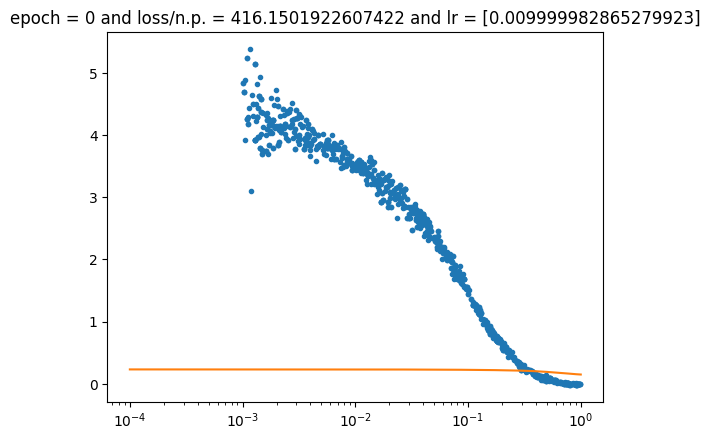

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Hyperparameters for the CNN model
n_features = 1        # Number of input features (for this example, we only have one input feature: 'x')
n_neurons_1 = 32       # Number of neurons in the first hidden layer
n_neurons_2 = 16       # Number of neurons in the second hidden layer
n_outputs = 1         # Number of output features (for regression, this is usually 1)
learning_rate = 0.01 # Learning rate for the optimizer, controls how much the model weights are adjusted during training
weight_decay  = 0.0001    # Adjusting regularization strength is an important step to control overfitting or underfitting in your model. Regularization adds a penalty to the loss function to discourage the model from fitting noise or over-complicating its parameters.
l1_lambda = 0.001  # Regularization strength
batch_size = 256      # Number of samples per mini-batch for training
n_epochs = 1200        # Number of complete passes through the training dataset



for i in range(100):
  x_boot, y_boot, dy_boot = bootstrap(x_train, y_train, dy_train, len(x_train))

  model = Torch_Model(n_features=1, n_neurons1=n_neurons_1, n_outputs=1).to(device)
  # Define loss function and optimizer
  criterion = ChiSquareLoss()  # Error for regression
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


  # Using a Learning Rate Scheduler PyTorch provides several schedulers to adjust the learning rate during training.
  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)  # T_max is the total number of epochs

  train_dataset = TensorDataset(x_boot, y_boot, dy_boot)
  train_loader = DataLoader(train_dataset, batch_size=batch_size)

  test_dataset = TensorDataset(x_test, y_test, dy_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  fig, ax = plt.subplots()

  train_losses = []
  test_losses = []



  for epoch in range(n_epochs):
      # Training
      model.train()
      train_loss = 0.0

      for x_batch, y_batch, dy_batch in train_loader:
          outputs = model(x_batch)


          loss = criterion(outputs, y_batch, dy_batch)
          # L1 Regularization Penalizes the absolute values of the weights, promoting sparsity (some weights are driven to zero).
          l1_penalty = sum(param.abs().sum() for param in model.parameters())
          loss += l1_lambda * l1_penalty

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()

          nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # Clip gradient norm


          optimizer.step()

          train_loss += loss.item()
      train_losses.append(train_loss)

      scheduler.step()

      # Testing
      with torch.no_grad():
        model.eval() # Put the model in evaluation mode
        test_loss = 0.0
        for x_batch, y_batch, dy_batch in test_loader:
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch, dy_batch)

          l1_penalty = sum(param.abs().sum() for param in model.parameters())
          loss += l1_lambda * l1_penalty

          test_loss += loss.item()
        test_losses.append(test_loss)



      if epoch % 400 == 0 or epoch == n_epochs - 1 :


        clear_output(wait=True)
        plt.gca().clear()
        # clear the axes

        plt.xscale('log')
        plt.plot(x_boot, y_boot, ".")
        plot_network(model)
        # plot everything

        plt.title(f"epoch = {epoch} and loss/n.p. = {train_loss/len(train_loader)} and lr = {scheduler.get_last_lr()}")
        display(fig)

  torch.save(model, f'/content/drive/MyDrive/PHYS 496/Models/replica{i+1}.pth')





In [46]:
n_replicas = 100
replica = []

for i in range(100):
  replica.append(torch.load(f"/content/drive/MyDrive/PHYS 496/Models/replica{i+1}.pth",weights_only=False))

In [47]:
# Read the data from the file and create a pandas DataFrame

df = pd.read_csv(filename1,

sep="\s+", # The separator is whitespace

skiprows=lines_to_skip, # Skip the first 5 lines

usecols=[0, 1, 2], # Only use the first three columns (x, cv, sd)

names=columns) # Name the columns as defined above

In [48]:
x_test1 = torch.tensor(df['x'].values.reshape(-1, 1)).float().to(device) # Input features (x)

y_test1 = torch.tensor(df['gluon_cv'].values.reshape(-1, 1)).float().to(device) # Input values (y)

dy_test1 = torch.tensor(df['gluon_sd'].values.reshape(-1, 1)).float().to(device) # Input errors (dy)




In [51]:
predictions = []

for i in range(n_replicas):

  replica[i].eval() # Put the model in evaluation mode
  predictions.append(replica[i](x_test1).detach().cpu().numpy())


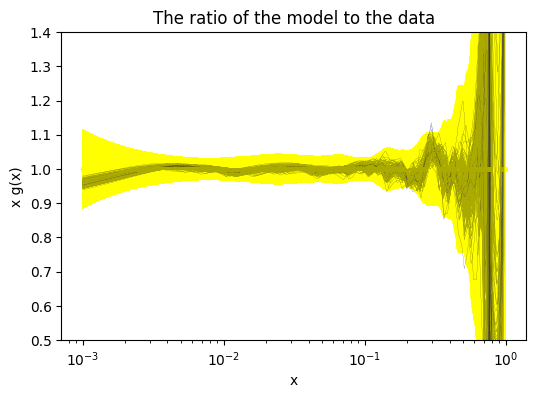

In [54]:

# Create a figure

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i in range(n_replicas):

  ax.plot(x_test1.detach().cpu().numpy(), predictions[i].flatten()/df['gluon_cv'].to_numpy(), color='darkblue',lw=0.1) # Model results

  ax.errorbar(df['x'], df['gluon_cv']/df['gluon_cv'], np.abs(df['gluon_sd']/df['gluon_cv']), fmt='.', color='yellow', label='Validation data', alpha=0.01) # Plot the true test values

  ax.axhline(0, color='k', linewidth=0.5) # Draw a horizontal line at y=0 for reference

  ax.set_title("The ratio of the model to the data") # Title for the train data plot

  ax.set_xlabel("x") # X-axis label

  ax.set_ylabel("x g(x)") # Y-axis label

  ax.set_ylim(0.5, 1.4) # Set limits for the Y-axis

  #ax.legend()

  ax.set_xscale('log')